# Import Packages

In [1]:
import glob
import os
import warnings
from matplotlib import style

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from hyperopt import fmin, tpe, hp, space_eval

In [2]:
style.use('dark_background')   # let graphs clear in the dark background of VScode
plt.rcParams['font.sans-serif']=['SimHei']   # Avoid abnormal display of Chineses Lables 
plt.rcParams['axes.unicode_minus'] = False   # Avoid abnormal dsiplay of '-'
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings("ignore")

# Load Data

In [3]:
path = 'input/store-sales-time-series-forecasting/' 

df_hoilday = pd.read_csv(path + 'holidays_events.csv')
df_oil = pd.read_csv(path + 'oil.csv')
df_store = pd.read_csv(path + 'stores.csv')
df_transaction = pd.read_csv(path + 'transactions.csv')

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

df_name = ['df_hoilday', 'df_oil', 'df_store', 'df_transaction', 'df_train', 'df_test']


# Data Pre-processing

## Real Holiday Celebration Dates

In [4]:
df_hoilday['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [5]:
# Real Holiday Celebration Dates Coding (-1/0/1)
df_hoilday_real = df_hoilday[df_hoilday['transferred'] == False]

df_hoilday_real['hoilday_code'] = 0

for i in range(df_hoilday_real.shape[0]):
    if df_hoilday_real['type'].iloc[i] == 'Work Day':
        df_hoilday_real['hoilday_code'].iloc[i] = -1
    elif df_hoilday_real['type'].iloc[i] in ['Holiday', 'Transfer', 'Additional', 'Bridge']:
        df_hoilday_real['hoilday_code'].iloc[i] = 1

df_hoilday_real

,date,type,locale,locale_name,description,transferred,hoilday_code
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1
...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1


## Four kind of Event Date

In [6]:
df_hoilday[df_hoilday['type']== 'Event'].description.unique()

array(['Dia de la Madre', 'Inauguracion Mundial de futbol Brasil',
       'Mundial de futbol Brasil: Ecuador-Suiza',
       'Mundial de futbol Brasil: Ecuador-Honduras',
       'Mundial de futbol Brasil: Ecuador-Francia',
       'Mundial de futbol Brasil: Octavos de Final',
       'Mundial de futbol Brasil: Cuartos de Final',
       'Mundial de futbol Brasil: Semifinales',
       'Mundial de futbol Brasil: Tercer y cuarto lugar',
       'Mundial de futbol Brasil: Final', 'Black Friday', 'Cyber Monday',
       'Terremoto Manabi', 'Terremoto Manabi+1', 'Terremoto Manabi+2',
       'Terremoto Manabi+3', 'Terremoto Manabi+4', 'Terremoto Manabi+5',
       'Terremoto Manabi+6', 'Terremoto Manabi+7', 'Terremoto Manabi+8',
       'Terremoto Manabi+9', 'Terremoto Manabi+10', 'Terremoto Manabi+11',
       'Terremoto Manabi+12', 'Terremoto Manabi+13',
       'Terremoto Manabi+14', 'Terremoto Manabi+15',
       'Terremoto Manabi+16', 'Terremoto Manabi+17',
       'Terremoto Manabi+18', 'Terremoto 

In [7]:
# Dia de la madre
df_Madre = df_hoilday[df_hoilday['description'] == 'Dia de la Madre']
df_Madre['Madre_code'] = 1

# Mundial de futbol
df_worldcup = df_hoilday[df_hoilday['description'].str.contains('Mundial de futbol', na=False)]
df_worldcup['worldcup_code'] = 1

# Shopping event
df_shopping = df_hoilday[df_hoilday['description'].str.contains('Black Friday|Cyber Monday', regex=True, na=False)]
df_shopping['shopping_code'] = 1

# Terremoto Manabi
df_earthquake = df_hoilday[df_hoilday['description'].str.contains('Terremoto Manabi', na=False)]
list = []
for i in range(df_earthquake.shape[0]):
    list.append(i+1)
df_earthquake['earthquake_day'] = list

## Fill in Oil Prices

In [8]:
if 'date' in df_oil.columns:
    df_oil['date'] = pd.to_datetime(df_oil['date'] , format="%Y-%m-%d")
    df_oil = df_oil.set_index('date').asfreq('D').fillna(method="bfill")
    df_oil.reset_index(inplace=True)
    df_oil['date'] = df_oil['date'].astype(str)
    
df_oil.head(14)

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.20
5,2013-01-06,93.20
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


## Merge all of data

In [9]:
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)
print(df_all.shape, df_train.shape, df_test.shape)

# store
df_all = df_all.merge(df_store, how='left', on='store_nbr')

# miss 'Santo Domingo de los Tsachilas' &  'Ecuador'
# hoilday
df_hoilday_real.rename(columns={'hoilday_code': 'hoilday_code_local'}, inplace=True)
df_all = df_all.merge(df_hoilday_real[['date', 'locale_name', 'hoilday_code_local']], how='left', left_on=['date','city'], right_on=['date', 'locale_name'])
df_all.drop('locale_name',axis=1, inplace=True)

df_national_hoilday = df_hoilday_real[df_hoilday_real['locale_name']=='Ecuador']
df_national_hoilday.rename(columns={'hoilday_code_local': 'hoilday_code_national'}, inplace=True)
df_all = df_all.merge(df_national_hoilday[['date', 'hoilday_code_national']], how='left', left_on=['date'], right_on=['date'])

# event
df_all = df_all.merge(df_Madre[['date', 'Madre_code']], how='left', left_on=['date'], right_on=['date'])
df_all = df_all.merge(df_worldcup[['date', 'worldcup_code']], how='left', left_on=['date'], right_on=['date'])
df_all = df_all.merge(df_shopping[['date', 'shopping_code']], how='left', left_on=['date'], right_on=['date'])
df_all = df_all.merge(df_earthquake[['date', 'earthquake_day']], how='left', left_on=['date'], right_on=['date'])

# oil
df_all = df_all.merge(df_oil, how='left', left_on=['date'], right_on=['date'])

# # transaction
# df_all = df_all.merge(df_transaction, how='left', left_on=['date','store_nbr'], right_on=['date','store_nbr'])

df_all.drop_duplicates(subset=['id'], keep='last', inplace=True, ignore_index=True)

print(df_all.shape)

(3029400, 6) (3000888, 6) (28512, 5)
(3029400, 17)


## Fill NaN value

In [10]:
df_all.fillna(value = 0, inplace=True)
print(df_all.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     3029400 non-null  int64  
 1   date                   3029400 non-null  object 
 2   store_nbr              3029400 non-null  int64  
 3   family                 3029400 non-null  object 
 4   sales                  3029400 non-null  float64
 5   onpromotion            3029400 non-null  int64  
 6   city                   3029400 non-null  object 
 7   state                  3029400 non-null  object 
 8   type                   3029400 non-null  object 
 9   cluster                3029400 non-null  int64  
 10  hoilday_code_local     3029400 non-null  float64
 11  hoilday_code_national  3029400 non-null  float64
 12  Madre_code             3029400 non-null  float64
 13  worldcup_code          3029400 non-null  float64
 14  shopping_code     

# Feature Engineering

## Oil price windows/lag feature

In [11]:
# Window
df_all['avg_oil'] = df_all['dcoilwtico'].rolling(7).mean()

# lag
for l in [1, 10, 31]:
    df_all[f'oil_lags{l}'] = df_all['dcoilwtico'].shift(l)

df_all.fillna(method='bfill', inplace=True)

## Oil price decomposed series feature

In [12]:
def decompse(df):
    df_decomposed = seasonal_decompose(df, model='additive', period = 31, extrapolate_trend=True)
    df_trend = df_decomposed.trend
    df_seasonal = df_decomposed.seasonal
    df_residual = df_decomposed.resid
    return df_trend, df_seasonal, df_residual

df_all['oil_trend'], df_all['oil_seasonal'], df_all['oil_residual'] = decompse(df_all['dcoilwtico'])

## Year / Month / Day

In [13]:
df_all['date'] = pd.to_datetime(df_all['date'] , format="%Y-%m-%d")
df_all['year'] = df_all.set_index('date').index.year
df_all['month'] = df_all.set_index('date').index.month
df_all['day'] = df_all.set_index('date').index.day

## New Year

In [14]:
df_all['date'] = pd.to_datetime(df_all['date'] , format="%Y-%m-%d")
df_all['NewYear'] = (df_all.set_index('date').index.dayofyear == 1)

## Weekend / Day of week

In [15]:
df_all['date'] = pd.to_datetime(df_all['date'] , format="%Y-%m-%d")
df_all['dofw'] = df_all.set_index('date').index.dayofweek
df_all['wd'] = 1
df_all.loc[df_all.dofw > 4, 'wd'] = 0

## Wage day

In [16]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
calendar['wageday']=0
calendar.loc[(calendar.index.to_timestamp().is_month_end) | (calendar.index.day == 15), 'wageday'] = 1
calendar.index = calendar.index.to_series().astype(str)
calendar.reset_index(inplace=True)
calendar.rename(columns={'index':'date'}, inplace=True)
calendar['date'] = pd.to_datetime(calendar['date'] , format="%Y-%m-%d")
df_all = df_all.merge(calendar, how='left', on='date')

## School season

In [17]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
school_season = []
for i, r in calendar.iterrows():
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season

calendar.index = calendar.index.to_series().astype(str)
calendar.reset_index(inplace=True)
calendar.rename(columns={'index':'date'}, inplace=True)
calendar['date'] = pd.to_datetime(calendar['date'] , format="%Y-%m-%d")
df_all = df_all.merge(calendar, how='left', on='date')

## Overview

In [18]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 32 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   date                   datetime64[ns]
 2   store_nbr              int64         
 3   family                 object        
 4   sales                  float64       
 5   onpromotion            int64         
 6   city                   object        
 7   state                  object        
 8   type                   object        
 9   cluster                int64         
 10  hoilday_code_local     float64       
 11  hoilday_code_national  float64       
 12  Madre_code             float64       
 13  worldcup_code          float64       
 14  shopping_code          float64       
 15  earthquake_day         float64       
 16  dcoilwtico             float64       
 17  avg_oil                float64       
 18  oil_lags1             

# Data Modeling

In [19]:
df_all.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,oil_seasonal,oil_residual,year,month,day,NewYear,dofw,wd,wageday,school_season
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0.000207,-0.000207,2013,1,1,True,1,1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,0.000122,-0.000122,2013,1,1,True,1,1,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,0.000064,-0.000064,2013,1,1,True,1,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,0.000071,-0.000071,2013,1,1,True,1,1,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,0.000015,-0.000015,2013,1,1,True,1,1,0,0


In [20]:
# Spilt Dataset
train_split = df_all[df_all['date']=='2016-01-01'].index[0]
val_split = df_all[df_all['date']=='2017-08-01'].index[0]
test_split = df_all[df_all['date']=='2017-08-16'].index[0]

# Specify categorical feature
df_all[['store_nbr', 'family', 'city', 'state', 'type', 'cluster', 'dofw']] = df_all[['store_nbr', 'family', 'city', 'state', 'type', 'cluster', 'dofw']].astype('category')

X_Train = df_all.loc[train_split:val_split].drop(['date', 'sales', 'id'], axis=1)
Y_Train = df_all['sales'].loc[train_split:val_split]
X_Val = df_all.loc[val_split:test_split].drop(['date', 'sales', 'id'], axis=1)
Y_Val = df_all['sales'].loc[val_split:test_split]
X_Test = df_all.loc[test_split:].drop(['date', 'sales', 'id'], axis=1)

# X_TrainAll = df_all.iloc[:test_split].drop(['sales'], axis=1)
# Y_TrainAll = df_all['sales'].iloc[:test_split]

print(X_Train.shape, Y_Train.shape)
print(X_Val.shape, Y_Val.shape)
print(X_Test.shape)

(1028214, 29) (1028214,)
(26730, 29) (26730,)
(28512, 29)


In [21]:
# Create Dataset
lgb_train = lgb.Dataset(X_Train, Y_Train, free_raw_data=False)
lgb_val = lgb.Dataset(X_Val,Y_Val, free_raw_data=False)
num_round = 1000

# Customize metirc function
def RMSLE(pred, train_data):
    labels = train_data.get_label()
    preds = pred
    if type(preds) is not int:
        preds[preds < 0] = 0
    return 'rmsle', np.sqrt(mean_squared_log_error(labels, preds)), False

## Training

In [22]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'regression',  
    'learning_rate': 0.05,  
    'bagging_freq': 5,  
    'verbose': -1,  
    'random_state': 1,

    'num_leaves': 30,  
    'bagging_fraction': 0.8,  
    'feature_fraction': 0.9,  
}

gbm = lgb.train(params, lgb_train, num_boost_round = num_round, feval=RMSLE)

In [23]:
# Training accuracy
train_pred = gbm.predict(X_Train)
train_pred[train_pred < 0] = 0
train_rmse = mean_squared_log_error(Y_Train, train_pred)
print('RMSLE of train Data:', np.sqrt(train_rmse))

RMSLE of train Data: 0.9154885721881342


In [40]:
train_pred

1945944       0.000000
1945945       0.000000
1945946       0.000000
1945947     365.229939
1945948       0.000000
              ...     
2974153     398.557423
2974154     114.253405
2974155    1457.716701
2974156      77.322404
2974157      19.263166
Length: 1028214, dtype: float64

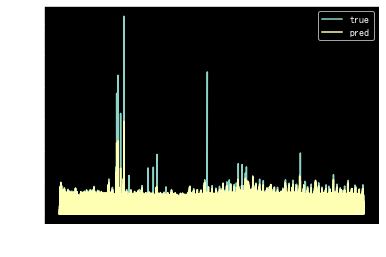

In [24]:
train_pred = pd.Series(train_pred, index = Y_Train.index)
plt.plot(Y_Train, label = 'true')
plt.plot(train_pred, label = 'pred')
plt.legend()
plt.show()

In [25]:
importances = gbm.feature_importance()
indices = np.argsort(importances)[::-1]

feat_labels = X_Train.columns[:]
for f in range(X_Train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) store_nbr                      6097.000000
 2) onpromotion                    4590.000000
 3) family                         3353.000000
 4) day                            2401.000000
 5) dcoilwtico                     2291.000000
 6) dofw                           1793.000000
 7) month                          1741.000000
 8) earthquake_day                 1587.000000
 9) oil_seasonal                   1079.000000
10) wd                             782.000000
11) hoilday_code_national          479.000000
12) cluster                        398.000000
13) year                           336.000000
14) oil_lags31                     292.000000
15) avg_oil                        265.000000
16) oil_residual                   262.000000
17) NewYear                        252.000000
18) city                           244.000000
19) school_season                  200.000000
20) oil_trend                      169.000000
21) Madre_code                     93.000000
22) oil_lags10            

## Validation

### Feature selection

In [26]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'learning_rate': 0.05,  # 学习速率
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': -1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
    'random_state': 1,
    'early_stopping_round': int(num_round/2),

    'num_leaves': 30,  # 叶子节点数
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'feature_fraction': 0.9,  # 建树的特征选择比例
}

In [27]:
Patience = 10 # Early stop condition
Best_rmsle = 4
Num_feature = 1
Best_interation = num_round
Best_feature = []
for t in range(Num_feature, X_Train.shape[1]):
    
    # Creat selected feature list
    select_feature = []
    for i in range(t):
        select_feature.append(feat_labels[indices[i]])
    
    X_Tr = X_Train[select_feature]
    X_Vl = X_Val[select_feature]

    # Training
    lgb_train = lgb.Dataset(X_Tr, Y_Train)
    lgb_val = lgb.Dataset(X_Vl,Y_Val)
    gbm = lgb.train(params, lgb_train, num_boost_round = num_round, valid_sets=lgb_val, verbose_eval=False, feval=RMSLE)

    # Prediction
    val_pred = gbm.predict(X_Vl, num_iteration=gbm.best_iteration)
    val_pred[val_pred < 0] = 0

    # Calculate the error and record the best setting
    Val_rmsle = mean_squared_log_error(Y_Val, val_pred)
    if Val_rmsle < Best_rmsle: 
        Best_rmsle = Val_rmsle
        Num_feature = t
        Best_feature = select_feature
        Best_interation = gbm.best_iteration
        Patience = 10
    else:
        Patience = Patience - 1
    
    print(t, Patience, '|' ,gbm.best_iteration, '/' ,Best_interation, '|' , np.sqrt(Val_rmsle), '/' ,np.sqrt(Best_rmsle))
    
    # Early stop
    if Patience == 0:
        break

1 9 | 36 / 1000 | 3.429913875861806 / 2.0
2 8 | 643 / 1000 | 2.327591924350304 / 2.0
3 10 | 150 / 150 | 0.8654412567217554 / 0.8654412567217554


KeyboardInterrupt: 

In [ ]:
print('Best RMSLE in Val :', np.sqrt(Best_rmsle))
print('Number of feature :', Num_feature)
print('Best number of Interation :', Best_interation)

Best RMSLE in Val : 0.7535493437102098
Number of feature : 22
Best number of Interation : 1993


In [ ]:
Best_feature = [] 
for i in range(Num_feature):  
    Best_feature.append(feat_labels[indices[i]])

X_Train = X_Train[Best_feature]
X_Val = X_Val[Best_feature]
X_Test = X_Test[Best_feature]

lgb_train = lgb.Dataset(X_Train, Y_Train)
lgb_val = lgb.Dataset(X_Val,Y_Val)

print(Best_feature)

['onpromotion', 'store_nbr', 'dcoilwtico', 'day', 'family', 'oil_seasonal', 'month', 'earthquake_day', 'dofw', 'wd', 'oil_residual', 'hoilday_code_national', 'cluster', 'year', 'avg_oil', 'city', 'school_season', 'oil_lags31', 'oil_trend', 'NewYear', 'hoilday_code_local', 'wageday']


### Parameters Tunning

In [ ]:
param_space = {
     'num_leaves': hp.choice('num_leaves', [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]),
     'bagging_fraction': hp.choice('bagging_fraction', [0.7, 0.8, 0.9, 1.0]),
     'feature_fraction': hp.choice('feature_fraction', [0.7, 0.8, 0.9, 1.0]),
     'num_round': hp.quniform('num_round', Best_interation, Best_interation+1000, 100)
}

In [ ]:
def gbm_tuning(parameters):
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',  
        'objective': 'regression',   
        'learning_rate': 0.05,  
        'bagging_freq': 5,  
        'verbose': -1,  
        'random_state': 1,

        'num_leaves': parameters['num_leaves'],  
        'bagging_fraction': parameters['bagging_fraction'],  
        'feature_fraction': parameters['feature_fraction'],  
    }

    gbm = lgb.train(params, lgb_train, num_boost_round = int(parameters['num_round']), feval=RMSLE)

    val_pred = gbm.predict(X_Val)
    val_pred[val_pred < 0] = 0
    val_rmse = mean_squared_log_error(Y_Val, val_pred)

    return np.sqrt(val_rmse)

In [ ]:
best = fmin(fn=gbm_tuning, space = param_space, algo=tpe.suggest, max_evals=100)
best_params = space_eval(param_space ,best)
print("best_params = ", best_params)

  4%|▍         | 4/100 [02:01<49:02, 30.65s/trial, best loss: 0.682165249651496]

In [ ]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'learning_rate': 0.05,  # 学习速率
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': -1,  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
    'random_state': 1,

    'num_leaves': best_params['num_leaves'],  # 叶子节点数
    'bagging_fraction': best_params['bagging_fraction'],  # 建树的样本采样比例
    'feature_fraction': best_params['feature_fraction'],  # 建树的特征选择比例
}

gbm = lgb.train(params, lgb_train, num_boost_round= int(best_params['num_round']), feval=RMSLE)

### Result

In [ ]:
val_pred = gbm.predict(X_Val)
val_pred[val_pred < 0] = 0
val_rmse = mean_squared_log_error(Y_Val, val_pred)
print('RMSLE of validation Data:', np.sqrt(val_rmse))

RMSLE of validation Data: 0.7158481830981559


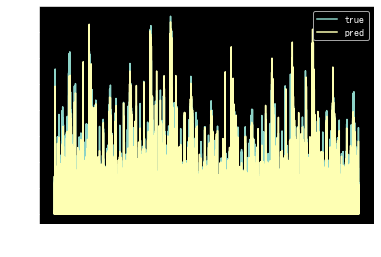

In [ ]:
val_pred = pd.Series(val_pred, index = Y_Val.index)
plt.plot(Y_Val, label = 'true' )
plt.plot(val_pred, label = 'pred')
plt.legend()
plt.show()

# Prediction

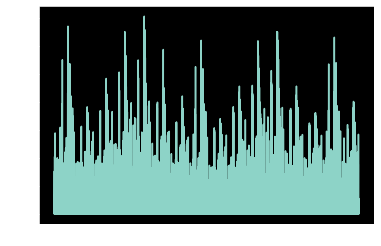

In [ ]:
test_pred = gbm.predict(X_Test)
test_pred[test_pred < 0] = 0
plt.plot(test_pred)
plt.show()

In [ ]:
df_sub = pd.read_csv(path + 'sample_submission.csv', index_col='id')
df_sub.sales = test_pred
df_sub.to_csv('submission.csv', index=True)